# **Training Pneumonia Classifier**



In [1]:
from google.colab import drive
drive.mount("/content/mydrive")# make path using / instead of \\ ... this may be redudant step
# train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
# train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
# test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
# test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
# val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
# val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


Mounted at /content/mydrive


In [2]:
%cd /content/mydrive/MyDrive/project/pnemonia_detection

/content/mydrive/MyDrive/project/pnemonia_detection


In [50]:
!pip install --upgrade tensorflow

#Download dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

In [ ]:
%cd chest-xray-pneumonia

In [ ]:
!unzip -q 'chest-xray-pneumonia.zip'


#Load Necessary Dependencies

In [5]:
%cd dataset

/content/mydrive/MyDrive/project/pnemonia_detection/dataset


In [7]:
# import system libs
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [52]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading The Dataset

In [ ]:
# @title
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)

        class_num = labels.index(label)
        for img in os.listdir(path):
          try:
              img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
              # Reshaping images to preferred size
              resized_arr = cv2.resize(img_arr, (img_size, img_size))
              data.append([resized_arr, class_num])
          except Exception as e:
              print(e)
    return np.array(data)

In [18]:
# Generate data paths with labels
path = '/content/mydrive/MyDrive/project/pnemonia_detection/dataset/chest-xray-pneumonia/chest_xray/chest_xray/'

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])

for x in train_pneu_cases:
    train_list.append([x, 1])

for x in test_normal_cases:
    test_list.append([x, 0])

for x in test_pneu_cases:
    test_list.append([x, 1])

for x in val_normal_cases:
    val_list.append([x, 0])

for x in val_pneu_cases:
    val_list.append([x, 1])

# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

In [53]:
train_df.head(5)

,image,label
0,/content/mydrive/MyDrive/project/pnemonia_dete...,1
1,/content/mydrive/MyDrive/project/pnemonia_dete...,1
2,/content/mydrive/MyDrive/project/pnemonia_dete...,1
3,/content/mydrive/MyDrive/project/pnemonia_dete...,1
4,/content/mydrive/MyDrive/project/pnemonia_dete...,1


In [54]:
test_df.head(5)

,image,label
0,/content/mydrive/MyDrive/project/pnemonia_dete...,1
1,/content/mydrive/MyDrive/project/pnemonia_dete...,0
2,/content/mydrive/MyDrive/project/pnemonia_dete...,1
3,/content/mydrive/MyDrive/project/pnemonia_dete...,1
4,/content/mydrive/MyDrive/project/pnemonia_dete...,1


In [23]:
val_df.head(5)

,image,label
0,/content/mydrive/MyDrive/project/pnemonia_dete...,1
1,/content/mydrive/MyDrive/project/pnemonia_dete...,1
2,/content/mydrive/MyDrive/project/pnemonia_dete...,0
3,/content/mydrive/MyDrive/project/pnemonia_dete...,0
4,/content/mydrive/MyDrive/project/pnemonia_dete...,1


# Data Preprocessing
check if the data is balanced

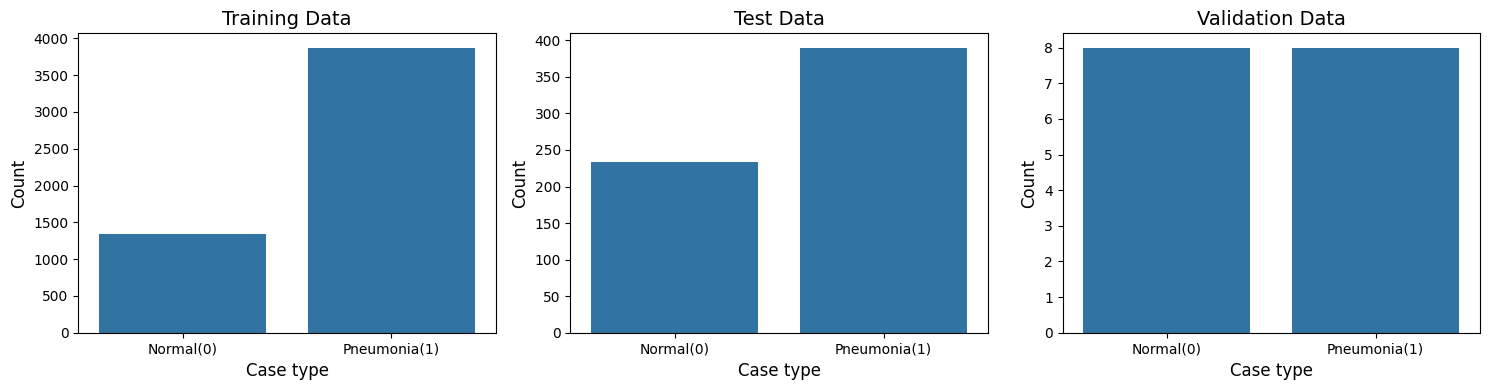

In [24]:
def plot_cases_count(df, title, ax):
    cases_count = df['label'].value_counts()

    sns.barplot(x=cases_count.index, y= cases_count.values, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(['Normal(0)', 'Pneumonia(1)'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Training Data
plot_cases_count(train_df, 'Training Data', axes[0])

# Plot for Test Data
plot_cases_count(test_df, 'Test Data', axes[1])

# Plot for Validation Data
plot_cases_count(val_df, 'Validation Data', axes[2])

plt.tight_layout()
plt.show()

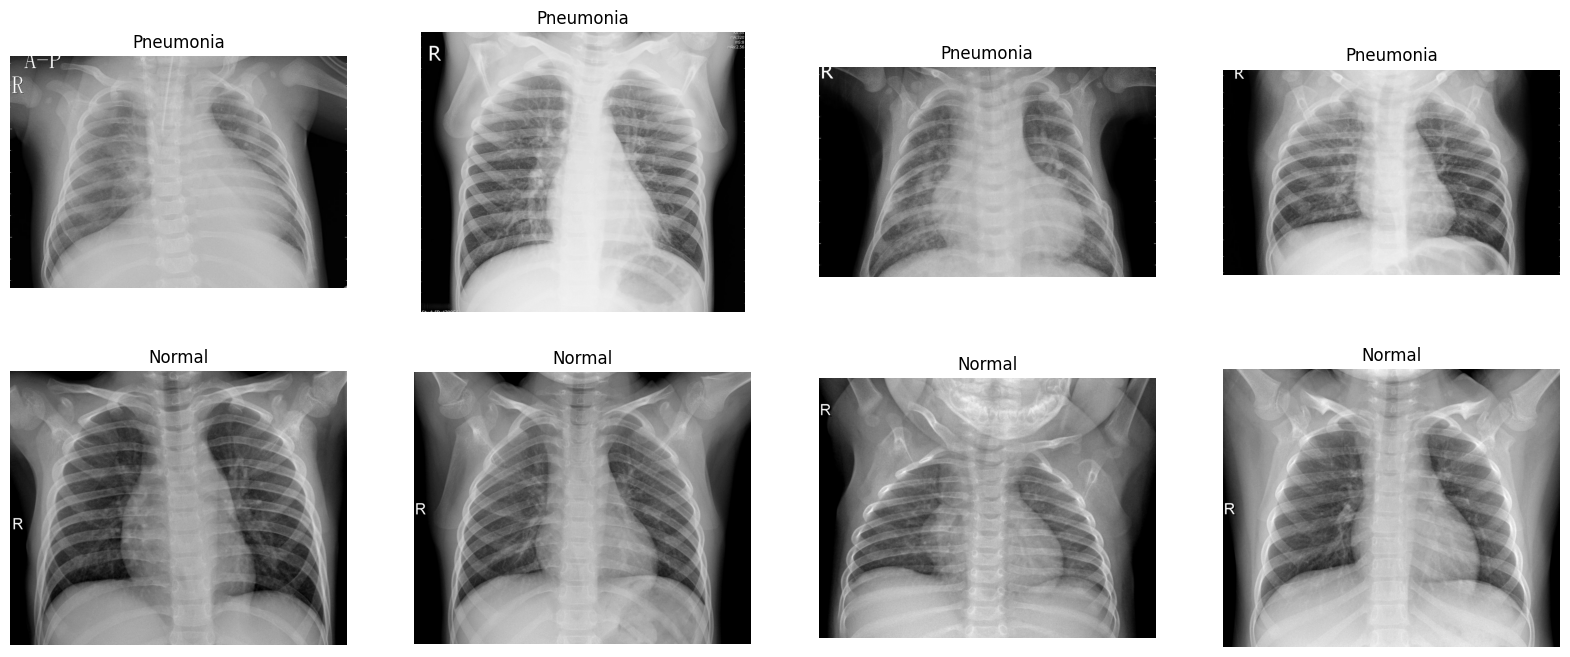

In [25]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

In [ ]:
# @title
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

#Preprocess the images

In [40]:
def get_image_data(img_df):
    n = len(img_df)
    img_data = np.zeros((n,224,224))
    label_data = np.zeros((n,))

    for i in range(n):
        img_path = img_df.loc[i,"image"]
        img_label = img_df.loc[i,"label"]

        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized = cv2.resize(img_arr, (224,224)) / 255

        img_data[i] = resized
        label_data[i] = img_label

    return img_data, label_data

In [26]:
# @title

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (224,224,1))

    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)

    return np.array(data), np.array(labels)

In [56]:

X_train, y_train = get_image_data(train_df)
X_test, y_test = get_image_data(test_df)
X_val, y_val = get_image_data(val_df)



print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224), Labels shape: (5216,)
Test data shape: (624, 224, 224), Labels shape: (624,)
Validation data shape: (16, 224, 224), Labels shape: (16,)


In [57]:
# reshape (batch, h, w) --> (batch, h, w, c)

X_train = X_train.reshape(-1, 224, 224, 1)
X_test = X_test.reshape(-1, 224, 224, 1)
X_val = X_val.reshape(-1, 224, 224, 1)

In [58]:
print(X_train.shape, y_train.shape, sep='\n')
print(X_test.shape, y_test.shape, sep='\n')
print(X_val.shape, y_val.shape, sep='\n')

(5216, 224, 224, 1)
(5216,)
(624, 224, 224, 1)
(624,)
(16, 224, 224, 1)
(16,)


#Create Image Data Generator

In [59]:
# crobed image size
batch_size = 16
img_size = (224, 224)

datagen = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images



# fit generator on our train features
datagen.fit(X_train)


In [60]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#Display Samples From Train Data

#- Create Model Architecture

In [61]:
# Create Model Structure
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu', input_shape=(224, 224, 1)))
model2.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=(3,3)))

model2.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=(3,3)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001, decay=1e-5)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=5)
history2 = model2.fit(datagen.flow(X_train,y_train, batch_size=16), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})


Epoch 1/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.2596 - loss: 0.9986 - val_accuracy: 0.3750 - val_loss: 1.1094
Epoch 2/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.5223 - loss: 0.6204 - val_accuracy: 0.6074 - val_loss: 0.8238
Epoch 3/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.7026 - loss: 0.4949 - val_accuracy: 0.7532 - val_loss: 0.5500
Epoch 4/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.7517 - loss: 0.4547 - val_accuracy: 0.6651 - val_loss: 0.7753
Epoch 5/100
 99/326 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.7740 - loss: 0.4053

KeyboardInterrupt: 

#Model summary

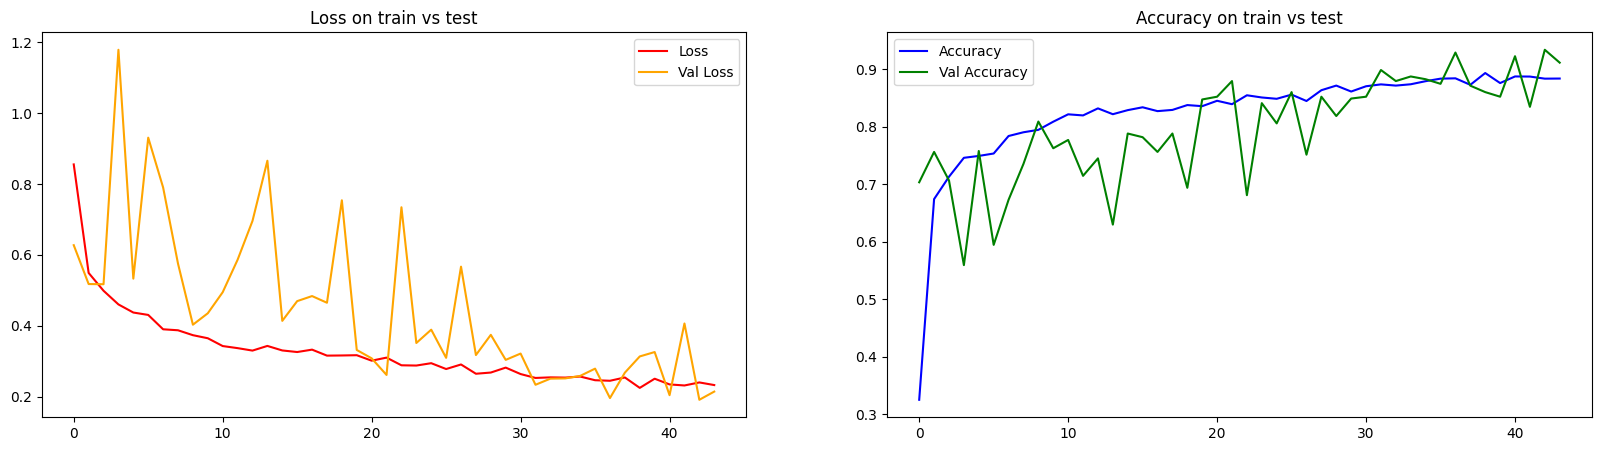

In [47]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history2.epoch, y=history2.history['loss'], color='red', label='Loss')
sns.lineplot(x=history2.epoch, y=history2.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history2.epoch, y=history2.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history2.epoch, y=history2.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [48]:
y_test_hat = model2.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


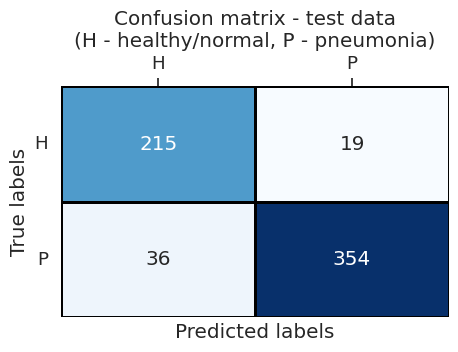

Classification report on test data
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       234
           1       0.95      0.91      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



In [49]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top')
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

In [ ]:
model2.save("best_model.h5")